In [1]:
import pandas as pd
import datetime as dt
import seaborn as sns
import numpy as np
from matplotlib import pyplot as plt
from RandomForestForTimeSeriesRegressor import RandomForestForTimeSeriesRegressor, BLOCK_TYPES

In [2]:
dataset = pd.read_csv('sp500_enriquecido.csv')

In [3]:
dataset = dataset.dropna()

In [4]:
calculatedFields = [col for col in dataset.columns if col not in ['Date', 'average_price']]
fieldsPrice = ["average_price"]
dataset['Date'] = pd.to_datetime(dataset['Date'])

In [5]:
def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn

In [6]:
from datetime import datetime

def generateRandomDate():
    max_date = pd.to_datetime(dataset['Date'].max())
    max_valid_date = max_date - pd.DateOffset(years=3)
    min_valid_date = pd.to_datetime(dataset['Date'].min())

    delta = (max_valid_date - min_valid_date).days
    random_days = np.random.randint(0, delta + 1)
    random_date0 = min_valid_date + pd.Timedelta(days=random_days)
    return random_date0

random_date = datetime.strptime("01/01/2018", "%d/%m/%Y") #generateRandomDate()

In [7]:
filtered_df = dataset[(dataset['Date'] >= random_date)]

In [8]:
#testRanges = [1, 91, 181, 271, 361, 451, 541, 631, 721, 791, 881, 971, 1061]
testRanges = [1, 31, 61, 91, 121, 151, 181, 211, 241, 271, 301, 331, 361]
train_days = 365
nJobs = 5
nEstimators = 100
block_size = 7

In [9]:
def getTrainTest(filtered_df0, pivote_date0, head=29):
    max_train_day = pivote_date0 + pd.DateOffset(days=train_days)
    blockDf = filtered_df0[(filtered_df0['Date'] >= pivote_date0) & (filtered_df0['Date'] <= max_train_day)]
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_train0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_train0 = aux[fieldsPrice].copy()
    
    blockDf = filtered_df0[filtered_df0["Date"] > max_train_day].head(head)
    
    aux = blockDf.copy()
    aux = aux.drop("Date", axis=1)
    X_test0 = aux[calculatedFields].copy()
    aux = aux.drop(calculatedFields, axis=1)

    Y_test0 = aux[fieldsPrice].copy()

    return X_train0, Y_train0, X_test0, Y_test0

In [10]:
basicRFPrecision = dict()
precisionNonOverlapping = dict()
precisionMovingBlock = dict()
precisionCircularBlock = dict()

resultBasicRF = dict()
resultNonOverlapping = dict()
resultMovingBlock = dict()
resultCircularBlock = dict()

In [11]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from math import sqrt

In [12]:
expectedValuesRf = []
predictedValuesRf = []
predictedValuesRftsNO = []
predictedValuesRftsMB = []
predictedValuesRftsCB = []

In [ ]:

X_train, Y_train, X_test, Y_test = getTrainTest(filtered_df, random_date, max(testRanges))
basicRF = RandomForestRegressor(n_jobs=nJobs, n_estimators=nEstimators, max_depth=10)
basicRF.fit(X_train, Y_train)
y_pred = basicRF.predict(X_test)
expectedValuesRf = Y_test["average_price"].tolist() 
predictedValuesRf = y_pred

rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10)
rfts.fit(X_train, Y_train)
y_pred = rfts.predict(X_test)
predictedValuesRftsNO = y_pred

rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[1])
rfts.fit(X_train, Y_train)
y_pred = rfts.predict(X_test)
predictedValuesRftsMB = y_pred

rfts = RandomForestForTimeSeriesRegressor(n_jobs=nJobs, n_estimators=nEstimators, block_size=block_size, max_depth=10, block_type=BLOCK_TYPES[2])
rfts.fit(X_train, Y_train)
y_pred = rfts.predict(X_test)
predictedValuesRftsCB = y_pred



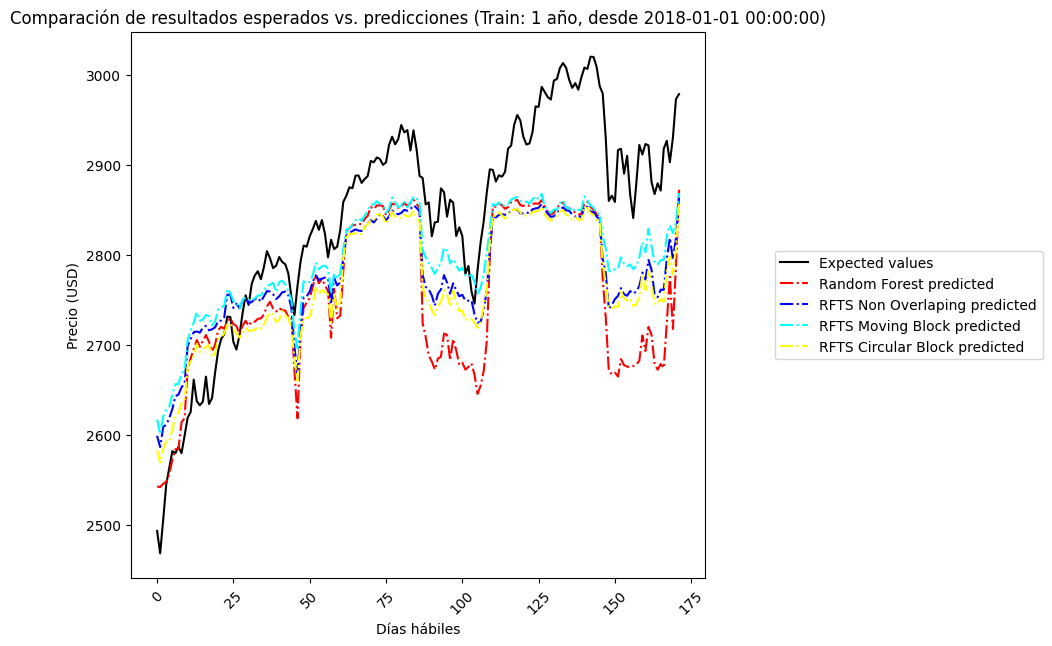

In [14]:
fig, ax1 = plt.subplots(figsize=(12, 6))
bp = ax1.plot(expectedValuesRf[:172], color='black', label="Expected values", linestyle='-')
bp0 = ax1.plot(predictedValuesRf[:172], color='red', label="Random Forest predicted", linestyle='-.')
bp1 = ax1.plot(predictedValuesRftsNO[:172], color='blue', label="RFTS Non Overlaping predicted", linestyle='-.')
bp2 = ax1.plot(predictedValuesRftsMB[:172], color='cyan', label="RFTS Moving Block predicted", linestyle='-.')
bp3 = ax1.plot(predictedValuesRftsCB[:172], color='yellow', label="RFTS Circular Block predicted", linestyle='-.')

plt.legend(loc='center right', bbox_to_anchor=(1.6, 0.5))

#plt.xticks(range(0, len(labels)), labels)
plt.tight_layout()
plt.xlabel("Días hábiles")
plt.ylabel("Precio (USD)")
plt.title(f"Comparación de resultados esperados vs. predicciones (Train: 1 año, desde {random_date})")
plt.xticks(rotation=45)

plt.show()